In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pyarrow as pa

from src.model.rbergomi import rBergomiMCModel
from qablet_contracts.timetable import py_to_ts, TS_EVENT_SCHEMA
from datetime import datetime
from qablet.base.flags import Stats
from src.utils import find_vol

In [ ]:
PATHS = 100_000
TIMESTEP = 1 / 250
ticker = "SPX"

H = 0.05
v0 = 0.025
eta = 2.3
rho = -0.9

In [ ]:
model = rBergomiMCModel()

prc_dt = datetime(2013, 8, 14)
rate = 0.0
times = np.array([0.0, 5.0])
rates = np.array([rate, rate])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

spot = 1
div_rate = 0.00  # should be .02
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

dataset = {
    "BASE": "USD",
    "PRICING_TS": py_to_ts(prc_dt).value,
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
    "MC": {
        "PATHS": PATHS,
        "TIMESTEP": TIMESTEP,
        "SEED": 1,
        "FLAGS": Stats.CASHFLOW,
    },
    "rB": {"ASSET": "SPX", "ALPHA": H - 0.5, "RHO": rho, "XI": v0, "ETA": eta},
}

In [ ]:
# We will define a forwards for various expirations
expirations = [
    # datetime(2013, 8, 16),  # in two days
    datetime(2013, 8, 23),  # weekly
    datetime(2013, 8, 30),  # weekly
    datetime(2013, 9, 20),  # monthly
    datetime(2013, 12, 20),  # quarterly
    datetime(2014, 3, 21),  # quarterly
    datetime(2014, 6, 20),  # quarterly
]
events = [
    {
        "track": "",
        "time": dt,
        "op": "+",
        "quantity": 1,
        "unit": ticker,
    }
    for dt in expirations
]

events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
fwd_timetable = {"events": events_table, "expressions": {}}
# print(fwd_timetable["events"].to_pandas())

In [ ]:
price, stats = model.price(fwd_timetable, dataset)

# Plot a Given Month

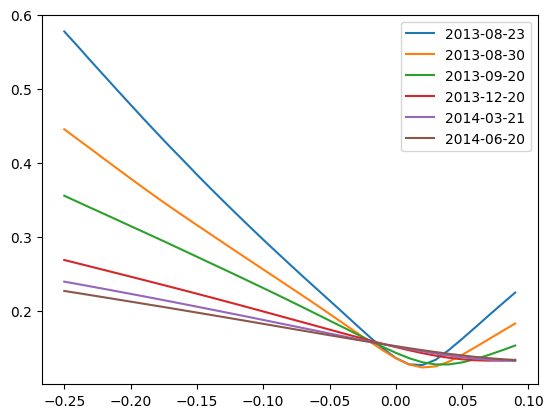

In [ ]:
atm_ivs = []
Ts = []
for i, exp in enumerate(expirations):
    cf = stats["CASHFLOW"][0][i]
    logK = np.arange(-0.25, 0.1, 0.01)
    K = spot * np.exp(logK)
    KC = K[..., None]  # Turn into a column vector

    prices = np.maximum(cf - KC, 0).mean(axis=1)

    T = (exp - prc_dt).days / 365.25
    iv_vec = [find_vol(p, spot, k, T, rate) for p, k in zip(prices, K)]
    plt.plot(logK, iv_vec, label=exp.strftime("%Y-%m-%d"))
    Ts.append(T)
    atm_ivs.append(iv_vec[25])
plt.legend()

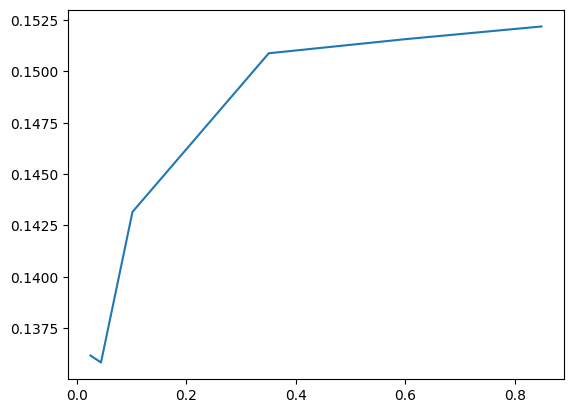

In [ ]:
plt.plot(Ts, atm_ivs, label="ATM IV")